# Multi-class Classification: Logistic Regression

This notebook contains the first part of the Programming Exercise 3 of the Andrew Ng's course on Coursera.

Implement a multi-class classification model using Logistic Regression to recognize handwritten numbers (0-9). We will extend the LogReg model from exercise 2. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and visualizing data

In [2]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('ex3data1.mat')

In [3]:
# The matrix X contains a set of 5000 grayscale training images (20px x 20px) where each pixel is a float representing the grayscale intensity. 
# The 400 pixels (20x20) of each image are actually unrolled into a 400 dimensions array 
# Each row of X represents a single image. Each column a pixel of all images

# X = [         px1  px2  px3  px4  ... px400 
# image 1 =>    0.0, 0.0, 0.2, 0.4  ...  0.0        
# image 2 =>    0.0, 0.1, 0.2, 0.2  ...  0.0        
# image 3 =>    0.0, 0.0, 0.0, 0.2  ...  0.0        
# ...           ...
# image 5000 => 0.0, 0.0, 0.1, 0.2  ...  0.0

# The matrix X contains a set of 5000 grayscale training images (20px x 20px) where each pixel is a float representing the grayscale intensity. 
# The 400 pixels (20x20) of each image are actually unrolled into a 400 dimensions array 
# Each row of X represents a single image. Each column a pixel of all images

# Y = [         number
# image 1 =>    1     
# image 2 =>    7        
# image 3 =>    3       
# ...           ...
# image 5000 => 9

X = data['X']
y = data['y']
X.shape, y.shape

((5000L, 400L), (5000L, 1L))

In [4]:
# Why does X have values <0 and >1???
print(X[0].min())
print(X[0].max())

-0.0575151143791
1.04748345631


In [5]:
# Helper functions to visualize the data (from https://github.com/kaleko/CourseraML/blob/master/ex3/ex3.ipynb)

import scipy.misc #Used to show matrix as an image
import random #To pick random images to display
import matplotlib.cm as cm #Used to display images in a specific colormap

def getDatumImg(row):
    # Function that is handed a single np array with shape 1x400, creates an image object from it, and returns it
    width, height = 20, 20
    square = row[0:].reshape(width,height)
    return square.T

def displayData(indices_to_display = None):
    # Function that picks 100 random rows from X, creates a 20x20 image from each, then stitches them together into a 10x10 grid of images, and shows it
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

array([[ 9,  7,  6,  2, 10,  1,  6,  7, 10,  2],
       [ 3,  1,  6,  8,  1,  1,  9,  7,  3,  4],
       [ 4,  4,  9,  4,  5,  7,  9, 10,  9,  5],
       [ 9,  5,  2,  8,  4,  6,  2,  8, 10,  4],
       [ 2,  9,  1,  3,  2,  1,  3,  4, 10,  6],
       [10,  8, 10,  6,  6,  8,  2,  2,  4,  2],
       [ 4, 10,  4,  7,  8, 10,  2,  8,  2,  8],
       [ 5,  5,  4,  2,  9,  5,  3,  1,  6,  1],
       [ 6,  4,  3,  3,  4,  4,  8,  1,  4,  9],
       [10,  7,  1,  9,  7,  6,  5,  5,  4,  7]], dtype=uint8)

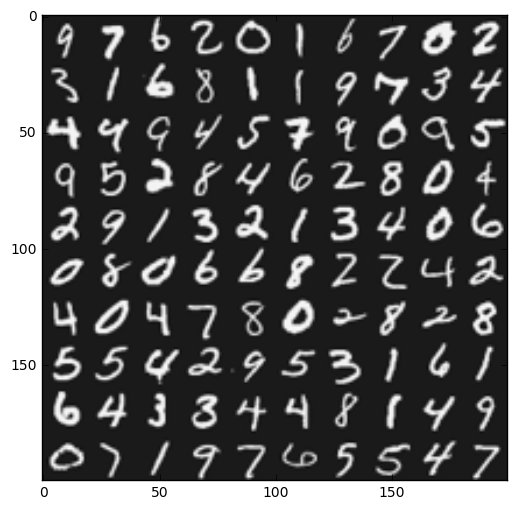

In [6]:
# let's visualize 100 random rows of X with the corresponding labels in y
indices_to_display = random.sample(range(X.shape[0]),100)
displayData(indices_to_display)
y[indices_to_display].reshape(10,10)

## Vectorized Logistic Regression Model

We will reuse much of the code from exercise 2. 

In [7]:
# sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
# define the hypotehsis function
def h(X, theta):
    return sigmoid(X*theta.T)

In [9]:
# cost function
def computeCost(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # compute first, second and regularization terms
    first = np.multiply(-y, np.log(h(X, theta)))
    second = np.multiply((1 - y), np.log(1 - h(X, theta)))
    reg = lmbda/(2*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2)) # all thetas except theta[0]
        
    return np.sum(first - second) / len(X) + reg

The gradient calculations is updated to a fully vectorized version.

In [10]:
# function that computes the gradient for each theta parameter (single step, not the gradient algorithm)
def computeGradient(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # init vars
    num_thetas = int(theta.ravel().shape[1])
    gradient = np.zeros(num_thetas)
       
    # compute gradient for each parameter theta (vectorized version)
    gradient = ((X.T * (h(X, theta) - y)) / len(X)).T + ((lmbda / len(X)) * theta)

    # theta0 is not regularized
    gradient[0, 0] = np.sum(np.multiply(h(X, theta) - y, X[:,0])) / len(X)
        
    return gradient

## Training the one-vs-all classification model

In [11]:
from scipy.optimize import minimize

# Function that manages the training of the 10 classifiers. It returns a matrix of num_classifiers x num_thetas
def one_vs_all_classification(X, y, num_classifiers, lmbda):
    
    # set vars
    num_samples = X.shape[0]
    num_thetas = X.shape[1] + 1

    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(num_samples), axis=1)

    # num_classifiers X num_thetas matrix for the parameters of each of the num_classifiers classifiers
    thetas_per_classifier = np.zeros((num_classifiers, num_thetas))
        
    # loop all classifiers ('1' to '0')
    for i in range(1, num_classifiers + 1): # labels are 1-indexed instead of 0-indexed, and 10 is '0'
        print "Optimizing for number %d..."%i

        # init thetas 
        theta = np.zeros(num_thetas)
        
        # transform y to binary class. y_i indicates whether it belongs to class i or not
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (num_samples, 1))
        
        # minimize the objective function
        fmin = minimize(fun=computeCost, x0=theta, args=(X, y_i, lmbda), method='TNC', jac=computeGradient)
        thetas_per_classifier[i-1,:] = fmin.x
    
    return thetas_per_classifier

Let's train the 10 classifiers (one per label, one per number to recognize) using the entire training set of 5000 samples 

In [12]:
num_classifiers = 10
lmbda = 1
thetas_per_classifier = one_vs_all_classification(X, y, num_classifiers, lmbda)

Optimizing for number 1...
Optimizing for number 2...
Optimizing for number 3...
Optimizing for number 4...
Optimizing for number 5...
Optimizing for number 6...
Optimizing for number 7...
Optimizing for number 8...
Optimizing for number 9...
Optimizing for number 10...


## Predict

Now let's do some predictions, using the same training set :(

In [13]:
def predict_all(X, thetas_per_classifier):
    # init vars
    num_samples = X.shape[0]
    num_thetas = X.shape[1]
    num_classifiers = thetas_per_classifier.shape[0]
    
    # insert column of ones for the intercept term
    X = np.insert(X, 0, values=np.ones(num_samples), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    thetas_per_classifier = np.matrix(thetas_per_classifier)
    
    # compute the class probability for each class on each training instance
    # class_probability is a matrix of num_samples x num_classifiers and each element represents the probability that the given sample (row) belongs to a given class (column)
    class_probability = h(X, thetas_per_classifier)
    
    # create array of the index with the maximum probability
    class_probability_argmax = np.argmax(class_probability, axis=1)
    
    # because the array is zero-indexed we need to add one for the true label prediction
    class_probability_argmax = class_probability_argmax + 1
    
    return class_probability, class_probability_argmax

In [14]:
# run predicton
raw_predictions_matrix, y_predictions = predict_all(X, thetas_per_classifier)

## Evaluate

### Accuracy


In [15]:
correct = [1 if a == b else 0 for (a, b) in zip(y_predictions, y)]
incorrect = [1 if a != b else 0 for (a, b) in zip(y_predictions, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('Accuracy = {0}%'.format(accuracy * 100))

Accuracy = 97.62%


Not too bad... :)

Let's explore a little bit more the classification job

### Which numbers are mistaken for which numbers?

Let's build a 10x10 matrix that will contain a histogram of all predictions. Rows indicate originally labeled numbers, columns indicate predicted. Thus, element (3,5) contains the amount of 3's that were predicted as 5.

In [16]:
# init matrix that will contain the histogram of all original labels vs predictions
predictions_histogram = np.zeros((10,10))

# loop all numbers (from 1 to 10, where 10 is '0') and all samples
for number in range(1, 11):
    print('Reviewing number %d' % number)
    for sample in range(X.shape[0]):
        # update the corresponding element in predictions_histogram
        predictions_histogram[y[sample]-1, y_predictions[sample]-1] = predictions_histogram[y[sample]-1, y_predictions[sample]-1] + 1

Reviewing number 1
Reviewing number 2
Reviewing number 3
Reviewing number 4
Reviewing number 5
Reviewing number 6
Reviewing number 7
Reviewing number 8
Reviewing number 9
Reviewing number 10


([<matplotlib.axis.YTick at 0x9fb6fd0>,
 <a list of 10 Text yticklabel objects>)

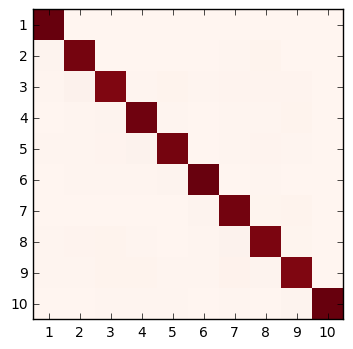

In [17]:
# plot the histogram matrix
plt.imshow(predictions_histogram, interpolation='none', cmap='Reds')
plt.xticks(range(0,10), range(1,11))
plt.yticks(range(0,10), range(1,11))

Difficult to see which numbers are more mistaken because the accuracy is pretty high and the amount of times the number is mistaken is low compared to the times is correctly classified... 

Let's print the same histogram removing the diagonal (only show wrong classifications)

([<matplotlib.axis.YTick at 0x9f245f8>,
 <a list of 10 Text yticklabel objects>)

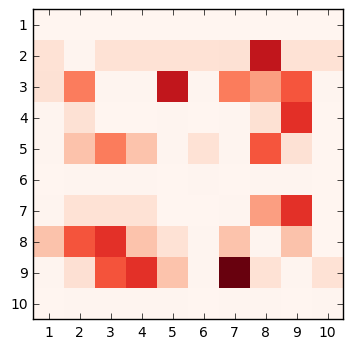

In [18]:
# plot the histogram matrix removing elements in the diagonal
plt.imshow(predictions_histogram - np.multiply(predictions_histogram, np.eye(10)), interpolation='none', cmap='Reds')
plt.xticks(range(0,10), range(1,11))
plt.yticks(range(0,10), range(1,11))

Interesting...
- Numbers [1,6,0] are always correcly classified
- These pairs of numbers are more mistaken for one another:
    - 2 & 8
    - 3 & 5
    - 4 & 9
    - 5 & 8
    - 7 & 9
    - 8 & 3
    - 9 & 4

Makes sense...

Let's see the first 100 mistaken handwritten numbers

matrix([[ 7,  8,  9,  8,  8,  4,  5, 10,  8,  8],
        [ 8,  6,  8,  1,  3,  5,  7,  5,  2,  5],
        [ 8,  9,  2,  5,  7,  2,  9,  8,  7,  5],
        [ 5,  8,  5,  9,  9,  9,  1,  7,  2,  8],
        [ 9,  9,  9,  9,  2,  9,  9,  3,  3,  2],
        [ 6,  4,  4,  3,  3,  8,  2,  8,  9,  8],
        [ 8,  8,  8,  9,  9,  2,  3,  8,  9,  9],
        [ 4,  8,  9,  9,  3,  4,  7,  2,  2,  7],
        [ 1,  9,  1,  9,  3,  4,  3,  2,  5,  3],
        [ 3,  2,  2,  3,  5,  2,  7,  4,  7,  7]], dtype=int64)

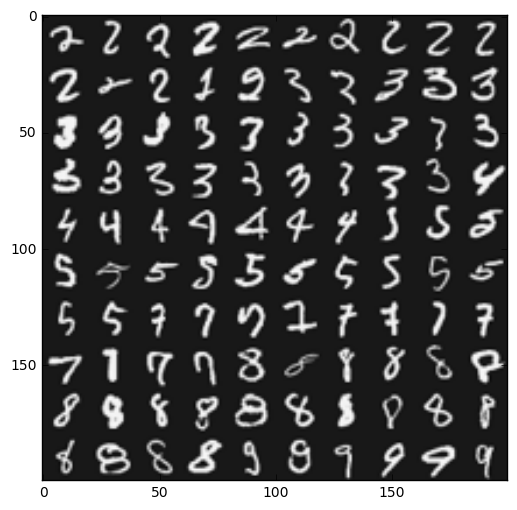

In [19]:
# print the original handwritten and predicted value of the incorrect classifications (first 100)
incorrect_indices = [i for i, e in enumerate(incorrect) if e != 0]
displayData(incorrect_indices[:100])
y_predictions[incorrect_indices[:100]].reshape(10,10)

Well, first element really looks like a 7, the second one is half 8...
Some others really show a bad classification...

In [22]:
type(y_predictions)

numpy.matrixlib.defmatrix.matrix

In [23]:
y_predictions.shape

(5000L, 1L)